# Fine-tuning PaliGamma for Image-to-JSON Extraction with QLoRA and SFT

In this notebook, we'll fine-tune Google's PaliGamma, a powerful multimodal vision-language model, to extract structured JSON data from receipt images. This is a practical application of multimodal learning that combines computer vision and natural language processing.


### Technical Approach

Our approach combines three state-of-the-art techniques:

1. **Multimodal Learning**: Leveraging PaliGemma's ability to process both images and text
2. **Parameter-Efficient Fine-Tuning**: Using QLoRA (Quantized Low-Rank Adaptation) to fine-tune efficiently
3. **Supervised Fine-Tuning (SFT)**: Training with explicit instruction following

This combination allows us to fine-tune a 3B parameter model on limited hardware while maintaining high performance.

## Setting Up the Environment

First, we need to install the necessary libraries:
- `datasets`: For handling and processing our training data
- `transformers`: For working with the PaliGamma model
- `trl`: For supervised fine-tuning (SFT)
- `bitsandbytes`: For quantization to enable memory-efficient training

These specific versions ensure compatibility with our fine-tuning approach.

In [1]:
!pip install datasets==3.6.0
!pip install transformers==4.47.1
!pip install trl==0.11.1
!pip install bitsandbytes==0.46.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.16.1 requires anyio<5.0.0,>=4.8.0, but you have 

In [ ]:
import torch
import json
import requests
from PIL import Image
from datasets import load_dataset
from peft import get_peft_model, LoraConfig
from transformers import PaliGemmaProcessor
from transformers import BitsAndBytesConfig
from transformers import PaliGemmaForConditionalGeneration
from trl import SFTConfig, SFTTrainer
from peft import PeftModel

import os
from dotenv import load_dotenv
from huggingface_hub import login

MAX_LENGTH = 1024

# Load environment variables from .env file
load_dotenv(os.path.join(os.path.dirname(__file__), '.env'))
login(
  token=os.getenv('HF_TOKEN'),
  add_to_git_credential=True
)


## Loading the Model and Dataset
We will use the CORD dataset for fine-tuning PaliGamma on the Image-to-JSON task.
The CORD dataset is particularly suitable for this task as it contains receipt images paired with structured JSON data representing the receipt content. This makes it ideal for training a model to extract structured information from visual inputs.

We split the dataset into training and validation sets to properly evaluate our model's performance during training.

In [2]:
device = "cuda"
model_id = "google/paligemma-3b-pt-224"

# Load dataset with appropriate size based on environment
cord_ds = load_dataset("naver-clova-ix/cord-v2")
cord_trains_ds = cord_ds["train"]
cord_validation_ds = cord_ds["validation"]

## Examining the Dataset

Let's visualize a sample image from the validation set to understand what kind of data we're working with. 

The CORD dataset contains images of receipts with varying layouts, text densities, and formats.

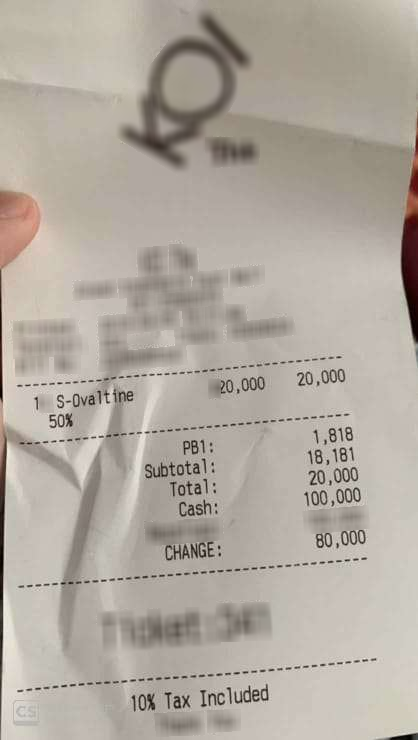

In [3]:
cord_validation_ds[2]['image']

## Examining the Ground Truth JSON Structure

Now we'll look at the ground truth JSON structure for the sample image. This helps us understand the expected output format our model needs to generate.

The ground truth JSON contains a set of key-value pairs. For our fine tuning task, we will br using only 'gt_parse' key to extract the parsed JSON.

So, here is a an expected output for the sample image above:



In [ ]:
json.loads(cord_validation_ds[2]['ground_truth'])['gt_parse']

{'menu': {'nm': 'S-Ovaltine 50%',
  'unitprice': '20,000',
  'cnt': '1',
  'price': '20,000',
  'vatyn': '10% Tax Included'},
 'sub_total': {'subtotal_price': '18,181', 'tax_price': '1,818'},
 'total': {'total_price': '20,000',
  'cashprice': '100,000',
  'changeprice': '80,000'}}

Also, for data exploration purposes I decided to check an average length of the ground truth labels in the train and validation datasets. It is to make sure that the complexity of both datasets is similar.

In [ ]:
import numpy as np

train_labels_len = [len(str(json.loads(cord_trains_ds[i]['ground_truth'])['gt_parse'])) for i in range(len(cord_trains_ds))]
val_labels_len = [len(str(json.loads(cord_validation_ds[i]['ground_truth'])['gt_parse'])) for i in range(len(cord_validation_ds))]

print("Average number of characters in gt labels in train dataset", np.mean(train_labels_len))
print("Average number of characters in gt labels in val dataset", np.mean(val_labels_len))

Average number of characters in gt labels in train dataset 322.665
Average number of characters in gt labels in val dataset 290.59


We will be fine-tuning the model on 800 images from train dataset and testing the performance of the model on 100 images from validation dataset.

In [89]:
cord_trains_ds.shape

(800, 2)

In [88]:
cord_validation_ds.shape

(100, 2)

## Creating the Data Processing Function

Here we define a custom collate function that:

1. Prepares the input text prompt with the special tokens `<image> <bos> Extract JSON`
2. Processes the images to the format expected by PaliGamma (converting to RGB)
3. Extracts and formats the ground truth JSON labels
4. Uses the PaliGamma processor to tokenize both inputs and outputs
5. Converts the tokens to bfloat16 format and moves them to the GPU

This function is crucial for preparing our data in a format that the model can process efficiently.

In [6]:
processor = PaliGemmaProcessor.from_pretrained(model_id)
def collate_fn(examples):
        texts = [f"<image> <bos> Extract JSON " for example in examples]
        images = [example["image"].convert("RGB") for example in examples]
        labels = [str(json.loads(example['ground_truth'])['gt_parse']) for example in examples]

        tokens = processor(text=texts, images=images, suffix=labels, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
        tokens = tokens.to(torch.bfloat16).to(device)
        return tokens


## Model Architecture and Fine-tuning Approach

### Why QLoRA for Fine-tuning?

QLoRA (Quantized Low-Rank Adaptation) offers several important advantages:

1. **Memory Efficiency**: By quantizing the base model to 4 bits, we reduce memory requirements by up to 75% compared to full fine-tuning.

2. **Parameter Efficiency**: LoRA updates only a small subset of parameters (0.385% in our case), making fine-tuning much more efficient.

3. **Performance Preservation**: QLoRA maintains most of the performance of full fine-tuning while being much more resource-efficient.

4. **Adaptability**: This approach allows fine-tuning on consumer hardware (like a single GPU) that would otherwise be impossible for a 3B parameter model.

In this case, we used Nvidia L4 GPU with the 16GB of memory and the total training time was 50 minutes, running ~$0.88 on GCP Colab Enterprise. 

## Configuring Quantization and LoRA

We set up two key configurations for efficient fine-tuning:

1. **BitsAndBytesConfig**: Enables 4-bit quantization (NF4 format) with bfloat16 compute dtype
   - This dramatically reduces the memory footprint of the model, allowing us to fine-tune on consumer GPUs
   - NF4 is a specialized 4-bit format optimized for language models

2. **LoraConfig**: Configures Low-Rank Adaptation parameters
   - `r=8`: Sets the rank of the LoRA decomposition (balancing parameter efficiency and model capacity)
   - `target_modules`: Specifies which model components to apply LoRA to (attention and MLP components)
   - `task_type`: Specifies we're fine-tuning for causal language modeling

This combination of quantization and LoRA represents the state-of-the-art in parameter-efficient fine-tuning, allowing us to adapt large models with minimal computational resources while maintaining performance.

In [7]:
# Configure BitsAndBytes for 4-bit quantization (CUDA only)
bnb_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_compute_dtype=torch.bfloat16
)

# LoRA configuration
lora_config = LoraConfig(
      r=8,
      target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
      task_type="CAUSAL_LM",
)

## Loading the Model with Quantization and LoRA

Now we:

1. Load the PaliGamma model with 4-bit quantization
2. Apply the LoRA configuration to make it trainable
3. Print the trainable parameters to verify our setup

The output shows that only about 0.385% of the parameters are trainable (11.3M out of 2.9B), demonstrating the parameter efficiency of our approach. This is the essence of QLoRA - we can fine-tune a multi-billion parameter model by updating only a small fraction of parameters.

The model architecture combines:
- A vision encoder (based on SiglipVisionModel) that processes the image
- A multimodal projector that maps visual features to the language space
- A language model (based on Gemma) that generates the structured JSON output

In [8]:
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters() # trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


## Configuring Supervised Fine-Tuning

Here we configure the SFT (Supervised Fine-Tuning) parameters using `SFTConfig`:

1. **Training Parameters**:
   - `output_dir`: Directory to save the model and push to Hub
   - `num_train_epochs`: 3 complete passes through the training data
   - `batch_size`: 1 sample per device (effective batch size = 16 with gradient accumulation)
   - `gradient_accumulation_steps`: 16 steps before updating weights
   - `learning_rate`: 2e-4, based on QLoRA paper recommendations

2. **Optimization Parameters**:
   - `gradient_checkpointing`: Reduces memory usage by recomputing activations during backprop
   - `optim`: Using fused AdamW for efficient optimization
   - `bf16`: Using bfloat16 precision for training
   - `lr_scheduler_type`: Cosine learning rate schedule
   - `max_grad_norm`: 0.3 to prevent gradient explosion
   - `warmup_ratio`: 0.03 for stable training start

3. **Evaluation and Saving**:
   - Evaluation every 5 steps
   - Model saving every 10 steps
   - Early stopping with best model selection based on validation loss

4. **Integration**:
   - Push to Hugging Face Hub
   - Report metrics to Weights & Biases

These parameters are carefully chosen based on best practices for fine-tuning large language models with PEFT techniques.

In [9]:
args = SFTConfig(
    output_dir="paligemma-imgtojson", # directory to save and repository id
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=1,          # batch size per device during training
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    learning_rate=2e-4,                     #  # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    lr_scheduler_type="cosine",
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper

    # Advanced evaluation settings
    evaluation_strategy="steps",
    eval_steps=5,
    save_strategy="steps",
    save_steps=10,
    logging_steps=5,

    # Early stopping
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Memory optimization
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    remove_unused_columns=False,

    # Experiment tracking
    push_to_hub=True,
    report_to="wandb", # push model to hub

    # SFT specific
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs={"skip_prepare_dataset": True}, # important for collator
    gradient_checkpointing_kwargs={"use_reentrant": False}, # use reentrant checkpointing
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Creating the SFT Trainer

Now we initialize the SFT Trainer with our model, configurations, and datasets:

1. The trainer combines:
   - Our QLoRA-adapted model
   - The SFT configuration
   - Training and validation datasets
   - Our custom data collator function
   - The LoRA configuration
   - The tokenizer from our processor

The SFT Trainer from the TRL library handles the complexities of training language models with teacher forcing, where the model learns to predict the next token given the previous tokens.


In [10]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=cord_trains_ds,
    eval_dataset=cord_validation_ds,
    data_collator=collate_fn,
    dataset_text_field="", # needs dummy value
    peft_config=lora_config,
    tokenizer=processor.tokenizer,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overf

## Training the Model

Now we start the training process. This will:

1. Initialize Weights & Biases for experiment tracking
2. Apply gradient checkpointing to save memory
3. Run training for 3 epochs
4. Evaluate on the validation set every 5 steps
5. Save checkpoints every 10 steps

The training progress table shows:
- Training loss decreasing from ~26 to ~3, indicating the model is learning
- Validation loss decreasing from ~1.37 to ~0.19, showing good generalization
- The best model is saved at checkpoint-135 with the lowest validation loss

This training process demonstrates the effectiveness of our QLoRA approach - we're able to efficiently fine-tune a 3B parameter model for a specific multimodal task with limited computational resources.

The decreasing validation loss curve indicates that the model is successfully learning to extract structured JSON data from receipt images without overfitting. 
See below screenshots from Weights & Biases:
![Train Charts from Weights & Biases](./wandb_charts/train_charts.png)
![Eval Charts from Weights & Biases](./wandb_charts/eval_charts.png)


In [11]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: veronika-yurchuk-v (veronika-yurchuk-v-). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
5,26.034600,1.371761
10,18.409500,0.872619
15,11.779600,0.529898
20,8.935600,0.400026
25,6.624100,0.347237
30,5.584300,0.306606
35,5.163400,0.284546
40,5.613800,0.265248
45,4.384800,0.252306
50,4.971600,0.245484


Could not locate the best model at paligemma-imgtojson/checkpoint-135/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=150, training_loss=5.5669218444824216, metrics={'train_runtime': 3750.51, 'train_samples_per_second': 0.64, 'train_steps_per_second': 0.04, 'total_flos': 1.4364271305919872e+16, 'train_loss': 5.5669218444824216, 'epoch': 3.0})

In [16]:
trainer.model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PaliGemmaForConditionalGeneration(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipSdpaAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1152, out_features=8, bias=False)
                    )
                    (lora_B)

In [17]:
trainer.state.log_history

[{'loss': 26.0346,
  'grad_norm': 12.362133026123047,
  'learning_rate': 0.0002,
  'epoch': 0.1,
  'step': 5},
 {'eval_loss': 1.3717608451843262,
  'eval_runtime': 40.0574,
  'eval_samples_per_second': 2.496,
  'eval_steps_per_second': 2.496,
  'epoch': 0.1,
  'step': 5},
 {'loss': 18.4095,
  'grad_norm': 15.840819358825684,
  'learning_rate': 0.00019941379571543596,
  'epoch': 0.2,
  'step': 10},
 {'eval_loss': 0.8726186156272888,
  'eval_runtime': 39.2243,
  'eval_samples_per_second': 2.549,
  'eval_steps_per_second': 2.549,
  'epoch': 0.2,
  'step': 10},
 {'loss': 11.7796,
  'grad_norm': 13.73476505279541,
  'learning_rate': 0.00019766205557100868,
  'epoch': 0.3,
  'step': 15},
 {'eval_loss': 0.529897928237915,
  'eval_runtime': 39.3483,
  'eval_samples_per_second': 2.541,
  'eval_steps_per_second': 2.541,
  'epoch': 0.3,
  'step': 15},
 {'loss': 8.9356,
  'grad_norm': 10.918956756591797,
  'learning_rate': 0.00019476531711828027,
  'epoch': 0.4,
  'step': 20},
 {'eval_loss': 0.400

In [18]:
# Run evaluation
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.19338783621788025, 'eval_runtime': 39.7349, 'eval_samples_per_second': 2.517, 'eval_steps_per_second': 2.517, 'epoch': 3.0}


In [ ]:
trainer.push_to_hub()

## Model Evaluation 

While decreasing validation loss curve indicates that the model is successfully learning to extract structured JSON data from receipt images without overfitting, it is always a good idea to evaluate the model's performance on a few examples from the validation set.

Let's compare the original model and the fine-tuned model on a few examples from the validation set.


In [ ]:
# Model IDs
base_model_id = "google/paligemma-3b-pt-224"
# Replace with your actual fine-tuned model path or HF repo ID
finetuned_model_id = "YOUR_HF_USERNAME/paligemma-imgtojson"  # Update this with your actual model path


Loading base model and fine-tuned model using PEFT adapter.

In [22]:
# Load models
print("Loading original model...")
original_model = PaliGemmaForConditionalGeneration.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map={"": 0} if device == "cuda" else None
)

print("Loading fine-tuned model...")
# First load the base model
finetuned_model = PaliGemmaForConditionalGeneration.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map={"":0} if device == "cuda" else None
)
# Then load the PEFT adapter
finetuned_model = PeftModel.from_pretrained(finetuned_model, finetuned_model_id)

# Set models to evaluation mode
original_model.eval()
finetuned_model.eval()


Loading original model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading fine-tuned model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/797 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PaliGemmaForConditionalGeneration(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipSdpaAttention(
                  (k_proj): lora.Linear(
                    (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1152, out_features=8, bias=False)
                    )
                    (lora_B): Module

In [95]:
def generate_prediction(model, image, prompt="<image> <bos> Extract JSON "):
    """Generate prediction from model given an image and prompt"""
    # First, tokenize just the prompt to get its token IDs
    prompt_tokens = processor.tokenizer(prompt, return_tensors="pt")
    prompt_token_ids = prompt_tokens.input_ids[0].tolist()

    # Process the input with the processor
    inputs = processor(text=prompt, images=image.convert("RGB"), return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the input token IDs before generation
    input_ids = inputs['input_ids'][0].tolist()

    # Generate with the model
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=1024,
            do_sample=False,
            temperature=1.0,
            num_beams=1,
        )

    # Get the full output token IDs
    output_ids = outputs[0].tolist()

    # Find where the input ends and the generated content begins
    # This works regardless of what the prompt text is
    generated_ids = outputs[0][len(input_ids):]

    # Decode only the generated part
    generated_text = processor.tokenizer.decode(generated_ids, skip_special_tokens=True)

    return generated_text

In [96]:
example_idx = 2
example = cord_validation_ds[example_idx]
image = example["image"]
ground_truth = json.loads(example["ground_truth"])['gt_parse']

print(f"\n===== Comparing models on example {example_idx} =====")
print(f"Ground truth: {ground_truth}", )

# Generate predictions
original_prediction = generate_prediction(original_model, image)
finetuned_prediction = generate_prediction(finetuned_model, image)


===== Comparing models on example 2 =====
Ground truth: {'menu': {'nm': 'S-Ovaltine 50%', 'unitprice': '20,000', 'cnt': '1', 'price': '20,000', 'vatyn': '10% Tax Included'}, 'sub_total': {'subtotal_price': '18,181', 'tax_price': '1,818'}, 'total': {'total_price': '20,000', 'cashprice': '100,000', 'changeprice': '80,000'}}


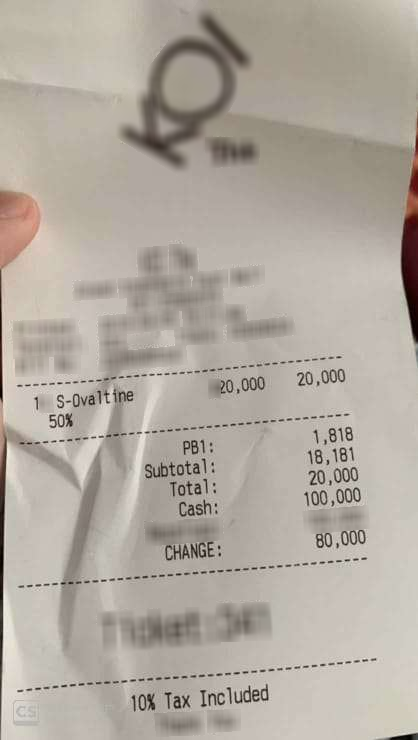

In [97]:
image

In [98]:
original_prediction

'receipt'

In [99]:
finetuned_prediction

"{'menu': {'nm': 'S-Ovaltine', 'unitprice': '20,000', 'cnt': '50X', 'price': '1,000'}, 'sub_total': {'subtotal_price': '20,000', 'tax_price': '2,000'}, 'total': {'total_price': '22,000', 'cashprice': '80,000', 'changeprice': '60,000', 'menuqty_cnt': '50X'}}"

Comparing the results of the original model and the fine-tuned model on a random example from the validation set. While it is not ideal, the improvement in the fine-tuned model is significant.

In [100]:
# Print results
print("\n----- Ground Truth -----")
print(ground_truth)

print("\n----- Original Model Prediction -----")
print(original_prediction)

print("\n----- Fine-tuned Model Prediction -----")
print(finetuned_prediction)



----- Ground Truth -----
{'menu': {'nm': 'S-Ovaltine 50%', 'unitprice': '20,000', 'cnt': '1', 'price': '20,000', 'vatyn': '10% Tax Included'}, 'sub_total': {'subtotal_price': '18,181', 'tax_price': '1,818'}, 'total': {'total_price': '20,000', 'cashprice': '100,000', 'changeprice': '80,000'}}

----- Original Model Prediction -----
receipt

----- Fine-tuned Model Prediction -----
{'menu': {'nm': 'S-Ovaltine', 'unitprice': '20,000', 'cnt': '50X', 'price': '1,000'}, 'sub_total': {'subtotal_price': '20,000', 'tax_price': '2,000'}, 'total': {'total_price': '22,000', 'cashprice': '80,000', 'changeprice': '60,000', 'menuqty_cnt': '50X'}}


## Future Work and Extensions

Potential extensions to this work include:

1. **Evaluation Metrics**: Implementing specialized metrics for structured data extraction accuracy, such as field-level precision/recall and structural similarity.

2. **More experiments with hyperparameters**: Experimenting with different hyperparameters, trying more aggressive quantization approach, etc to find the best configuration for the model.

3. **Applying different models**: Experimenting with different models, such as recent PaliGemma models with Gemma 3, to see if they perform better.

4. **Inference Optimization**: Exploring techniques like weight merging or distillation to improve inference speed while maintaining accuracy.

5. **Dataset Expansion**: Fine-tuning on additional document types beyond receipts to create a more versatile document processing model.

I am planning to implement and experiment with all of these in the future, so stay tuned!